In [24]:
#Importin libraries
import numpy as np 
import pandas as pd 
from sklearn import svm
import prince
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [9]:
#Importing train and preprocessing test data

train = pd.read_csv("/kaggle/input/inhibitors/cdk2_train.csv", header = None)
test = pd.read_csv("/kaggle/input/inhibitors/cdk2_test.csv", header = None)






y_train = np.array(train.iloc[:,0])
y_test = np.array(test.iloc[:,0])

colsindex= range(0, train.shape[1])

X_test = pd.DataFrame(test.iloc[:,1:], columns = None).fillna(0).astype('category')
X_train = pd.DataFrame(train.iloc[:,1:], columns = None).fillna(0).astype('category')
X_test = X_test.reindex(columns=X_train.columns)
X_test = X_test.astype(X_train.dtypes)


# Exploratory Data Analysis
I explore the Dataset. There are no missing values and all the features are 'black box'.
The train and the test set has significantly different target value distribution, so I will undersample the train data to make them similar. This difference however already indicates that the train and test set are not from the same distribution, which makes prediction more difficult.

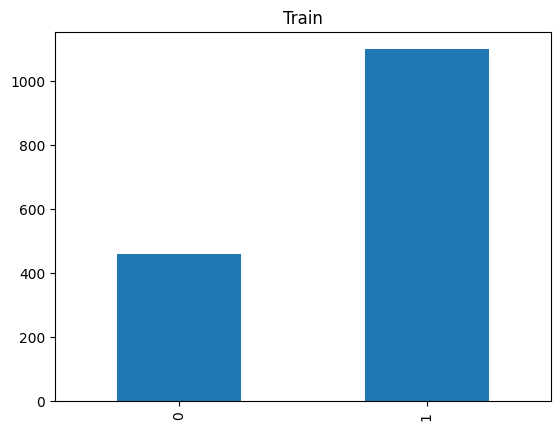

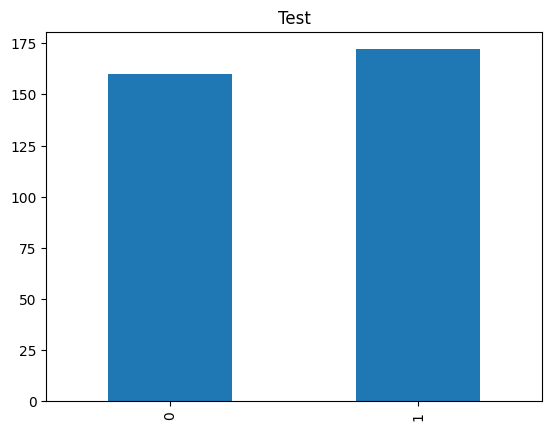

,1,2,3,4,5,6,7,8,9,10,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
count,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558,...,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558
unique,2,2,2,2,2,2,4,2,2,2,...,2,2,2,1,2,3,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,1554,1544,1540,1539,1539,1556,1539,1550,1556,1518,...,1555,1541,1555,1558,1556,1552,1547,1479,1550,1556


In [10]:
#EDA


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_train_series = pd.Series(y_train)
y_train_series.value_counts().sort_index().plot(kind='bar')
plt.title('Train')
plt.show()

y_train_test = pd.Series(y_test)
y_train_test.value_counts().sort_index().plot(kind='bar')
plt.title('Test')
plt.show()
X_train.describe()


In [11]:
#Undersampling train to match the distribution of test in terms of the target variable
train = train.drop(train[(train[0]== 1) & ((train.index%5 == 1) |(train.index%5 == 2)|(train.index%5 == 3) )].index)


I reduce the number of features using mca. This is important because with so many sparse features the model would overfit.

In [12]:
#Create MCA model
mca = prince.MCA(n_components=800)  # Specify the desired number of dimensions


#Fit the model and obtain the transformed data
X_train = mca.fit_transform(X_train)
X_test =mca.transform(X_test)


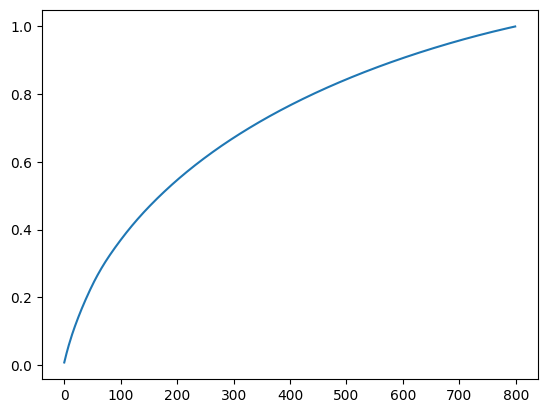

In [13]:
#calculating how many components explain what proportion of the variance 

eigenvalues = mca.eigenvalues_
total_variance = np.sum(eigenvalues)
explained_variance = eigenvalues / total_variance
cumulative_sum = np.cumsum(explained_variance)
plt.plot(cumulative_sum)


I define model creater functions, that tune the hyperparams of the given model and returns the model with the best hyperparams.

In [14]:
def CreateSVM():
    
# Define the parameter grid for hyperparameter tuning
    param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly', 'rbf'],
    'gamma': [0.1, 1, 10, 'scale', 'auto']
    }
    
    # Create an SVM model
    svm_model = svm.SVC(probability=True)
    
    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Create a new model with the best parameters
    SVM = svm.SVC(**best_params)
    
    
    # Train the model
    SVM.fit(X_train, y_train)
    
    # Make predictions
    print('SVM', best_score, best_params)
    return SVM

In [15]:
def CreateRandomForest():
    
    
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    # Create a Random Forest Classifier
    random_forest = RandomForestClassifier()
    
    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Create a new Random Forest Classifier with the best parameters
    best_random_forest = RandomForestClassifier(**best_params)
    best_random_forest.fit(X_train, y_train)
    print('forest', best_score, best_params)
    # Make predictions using the best Random Forest Classifier
    return best_random_forest

In [16]:
def CreategBoost():
    
    
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    # Create a Gradient Boosting Classifier
    gbm = GradientBoostingClassifier()
    
    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Create a new Gradient Boosting Classifier with the best parameters
    best_gbm = GradientBoostingClassifier(**best_params)
    best_gbm.fit(X_train, y_train)
    print('gboost', best_score, best_params)
    # Make predictions using the best Gradient Boosting Classifier
    
    return best_gbm

In [17]:
def CreateKNN():
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_neighbors': [21, 23],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute']
    }
    
    # Create a KNN Classifier
    knn = KNeighborsClassifier()
    
    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=30)
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Create a new KNN Classifier with the best parameters
    best_knn = KNeighborsClassifier(**best_params)
    best_knn.fit(X_train, y_train)
    print('KNN', best_score, best_params)
    # Make predictions using the best KNN Classifier
    return best_knn


I create some simpler models which do not require hyperparamtuning. Then I create the more complex models with the functions defined above.

In [18]:
# Create a Gaussian Naive Bayes classifier
naive_bayes = GaussianNB()

# Fit the classifier to the training data
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict(X_test)

print('Bayes',accuracy_score(y_test, y_pred))
# Make predictions on the test data

Bayes 0.5180722891566265


In [19]:
logreg = LogisticRegression()

# Fit the classifier to the training data
#logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
print('Logreg',accuracy_score(y_test, y_pred))
# Make predictions on the test data

Logreg 0.5180722891566265


In [20]:
#Running the hyperparameter tuning and creating the models
knn = CreateKNN()
SVM = CreateSVM()
gboost = CreategBoost()
forest = CreateRandomForest()

KNN 0.8151583710407241 {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}
SVM 0.8838238931486521 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
gboost 0.8844546129112045 {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
forest 0.87483922829582 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


I create a voting classifier to integrate the results from each classifier

In [21]:
#soft voting
ensamble= VotingClassifier(estimators=[('logreg', logreg),('SVM', SVM)],)

In [22]:
#hard voting
ensemble = VotingClassifier(
    estimators=[('knn', knn), ('SVM', SVM), ('gboost', gboost),('forest', forest), ('logreg', logreg), ('naive_bayes', naive_bayes)],
    voting='hard'  # Use majority voting
)

In [25]:
ensemble.fit(X_train, y_train)

# Make predictions on the test data using the ensemble classifier
y_pred = knn.predict(X_test)










accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print(set(y_pred))
asd = y_pred-y_test

Accuracy: 0.5180722891566265
Precision: 0.5180722891566265
Recall: 1.0
F1 score: 0.6825396825396826
{1}
